# Tutorial: Data-Driven Proposals in Gen _(with applications to Inverse Planning)_


### What is this tutorial about?

In our 
[introduction to modeling tutorial](Introduction%20to%20Modeling%20in%20Gen.jl), we used **Importance Sampling** for inference: the inference engine _proposed_ many possible explanations for a dataset, and then chose one. Importance sampling can be difficult to scale to more complex problems, because it is essentially "guessing and checking." If we ran importance sampling with 1000 particles, for example, 
the method would fail unless those 1000 proposed solutions (blind guesses, essentially)
contained _something_ close to the true answer. In complex problems, it is difficult
to "guess" (or "propose") an entire solution all at once.

This tutorial addresses the scalability problem while staying inside
the importance sampling framework: the inference in this notebook is all importance
sampling, but with **customized "data-driven" proposals**. Such proposals 
can be used to accelerate Monte Carlo inference, making importance sampling
feasible for a broader class of models. Data-driven proposals work by incorporating 
information from the observed data set to make better proposals for the 
latent variables in a generative model. Data-driven proposals can be based on heuristics,
or general-purpose _discriminative_ models, such as neural networks or random forests.
Many data-driven proposals have **trainable parameters**, which can be learned via gradient
descent using synthetic data simulated from the generative model itself. This training
process is sometimes called 'amortized inference' or 'inference compilation'.

Although we focus on using data-driven proposals with importance sampling in this notebook,
data-driven proposals can also be used with Markov Chain Monte Carlo (MCMC) and
sequential Monte Carlo (SMC), covered in [other](Iterative%20Inference%20in%20Gen.jl) [tutorials](Particle%20Filtering%20in%20Gen.jl).

### Application to Inverse Planning
This notebook begins by introducing a probabilistic model for the motion of 
an autonomous agent. The model itself demonstrates an important feature of
Gen: because it is embedded in Julia, we can use complex, black-box programs
as sub-routines in our models. The model we develop here uses an _RRT path planner_
to model the goal-directed motion of the agent.

After developing the model, we set out to improve the efficiency of inference. 
We show that we can improve the efficiency of inference in this model using
a custom proposal for the destination of the agent.

## Outline

**Section 1.** [A generative model of an autonomous agent](#model)

**Section 2.** [Writing a data-driven proposal as a generative function](#custom-proposal)

**Section 3.** [Using a data-driven proposal within importance sampling](#using)

**Section 4.** [Training the parameters of a data-driven proposal](#training)

In [1]:
using Gen, Distributions

In [ ]:
using Pkg; Pkg.instantiate()

   Resolving package versions...
    Updating `~/Documents/MIT/Fall 2022/9.66/project/gen-quickstart/Project.toml`
  [28b8d3ca] + GR v0.71.1
  No Changes to `~/Documents/MIT/Fall 2022/9.66/project/gen-quickstart/Manifest.toml`
Precompiling project...
  ✓ HTTP
  ✓ GR
  ✓ Plots
  3 dependencies successfully precompiled in 23 seconds. 187 already precompiled.
  2 dependencies precompiled but different versions are currently loaded. Restart julia to access the new versions


## 1: A generative model of an autonomous agent   <a name="model"></a>

We begin by writing a generative probabilistic model of the motion of an
intelligent agent that is navigating a two-dimensional scene. The model will
be *algorithmic* --- it will invoke a path planning algorithm implemented in
regular Julia code to generate the agent's motion plan from its destination
and its map of the scene.

First, we load some basic geometric primitives for a two-dimensional scene. We
implemented these already in an auxiliary Julia file:

In [5]:
include("../inverse-planning/geometric_primitives.jl");

┌ Info: Precompiling Luxor [ae8d54c2-7ccd-5906-9d76-62fc9837b5bc]
└ @ Base loading.jl:1664
[ Info: SnoopPrecompile is analyzing Luxor.jl code...


The file we loaded gives us the `Point` data type (imported from [Luxor.jl](https://juliagraphics.github.io/Luxor.jl/)), which has fields `x` and `y`.

In [6]:
point = Point(1.0, 2.0)
println(point.x)
println(point.y)

1.0
2.0


The file also defines an `Obstacle` data type, which represents a polygonal
obstacle in a two-dimensional scene, that is constructed from a list of
vertices. Here, we construct a square:

In [7]:
obstacle = Obstacle([Point(0.0, 0.0), Point(0.5, 0.0), Point(0.5, 1.0), Point(0.0, 1.0)])

Obstacle(Point[Point(0.0, 0.0), Point(0.5, 0.0), Point(0.5, 1.0), Point(0.0, 1.0)])

Next, we load the definition of a `Scene` data type that represents a
two-dimensional scene.

In [8]:
include("../inverse-planning/scene.jl");

The `Scene` data type represents a rectangle on the two-dimensional x-y plane
with a list of obstacles, which is initially empty.

In [9]:
scene = Scene(xmin=0, xmax=1, ymin=0, ymax=1)

Scene(0.0, 1.0, 0.0, 1.0, Obstacle[])

Obstacles can be added to a scene with the `add_obstacle!` function:

In [10]:
add_obstacle!(scene, obstacle);

The file we imported also defines functions that simplify the construction of obstacles:

`make_square(center::Point, size::Float64)` constructs a square-shaped
obstacle centered at the given point with the given side length:

In [11]:
square_obstacle = make_square(Point(.25, .75), 0.1)

Obstacle(Point[Point(0.2, 0.7), Point(0.3, 0.7), Point(0.3, 0.8), Point(0.2, 0.8)])

`make_line(vertical::Bool, start::Point, length::Float64,
thickness::Float64)` constructs an axis-aligned line (either vertical or
horizontal) with given thickness that extends from a given strating point for
a certain length:

In [12]:
vertical_wall_obstacle = make_line(false, Point(0.20, 0.40), 0.40, 0.02)

Obstacle(Point[Point(0.2, 0.4), Point(0.6000000000000001, 0.4), Point(0.6000000000000001, 0.42000000000000004), Point(0.2, 0.42000000000000004)])

We now construct a scene value that we will use in the rest of the notebook:

In [13]:
scene = Scene(xmin=0, xmax=1, ymin=0, ymax=1)
add_obstacle!(scene, make_square(Point(0.30, 0.20), 0.1))
add_obstacle!(scene, make_square(Point(0.83, 0.80), 0.1))
add_obstacle!(scene, make_square(Point(0.80, 0.40), 0.1))
horizontal = false
vertical = true
wall_thickness = 0.02
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.40), 0.40, wall_thickness))
add_obstacle!(scene, make_line(vertical, Point(0.60, 0.40), 0.40, wall_thickness))
add_obstacle!(scene, make_line(horizontal, Point(0.60 - 0.15, 0.80), 0.15 + wall_thickness, wall_thickness))
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.80), 0.15, wall_thickness))
add_obstacle!(scene, make_line(vertical, Point(0.20, 0.40), 0.40, wall_thickness));

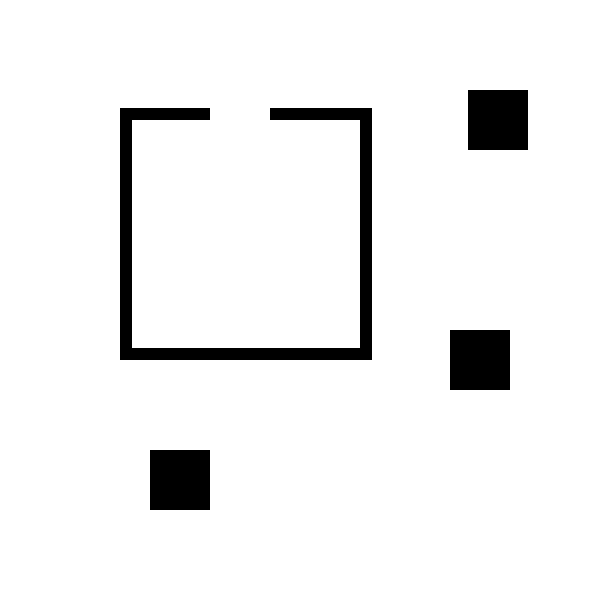

In [14]:
# We visualize the scene below.
include("../inverse-planning/viz.jl")
visualize() do
    draw_scene(scene)
end

Next, we load a file that defines a `Path` data type (a sequence of
`Point`s), and a `plan_path` method, which  uses a path planning algorithm
based on rapidly exploring random tree (RRT, [1]) to find a sequence of
`Point`s beginning with `start` and ending in `dest` such that the line
segment between each consecutive pair of points does not intersect any
obstacles in the scene. The planning algorithm may fail to find a valid path,
in which case it will return a value of type `Nothing`.

`path::Union{Path,Nothing} = plan_path(start::Point, dest::Point,
scene::Scene, planner_params::PlannerParams)`

[1] [_Rapidly-exploring random trees: A new tool for path planning._](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.35.1853&rep=rep1&type=pdf)
S. M. LaValle. TR 98-11, Computer Science Dept., Iowa State University, October 1998.

In [15]:
include("../inverse-planning/planning.jl");

Let's use `plan_path` to plan a path from the lower-left corner of the scene
into the interior of the box.

In [16]:
start = Point(0.1, 0.1)
dest = Point(0.5, 0.5)
planner_params = PlannerParams(rrt_iters=600, rrt_dt=3.0,
                               refine_iters=3500, refine_std=1.)
example_path = plan_path(start, dest, scene, planner_params)

Path(Point[Point(0.1, 0.1), Point(0.11429373737228857, 0.3167622653423008), Point(0.16086412844771186, 0.7003507551684728), Point(0.2199989299347878, 0.9046380701623751), Point(0.4180035486985809, 0.7965935278331517), Point(0.5, 0.5)])

We visualize the path below with the function `visualize` (defined in the
external file we loaded), which will visualize the path in the scene.
The start location is shown as a blue circle, the
destination as a red rhombus, and the path in orange. Run the cell above followed by
the cell below a few times to see the variability in the paths generated by
`plan_path` for these inputs.

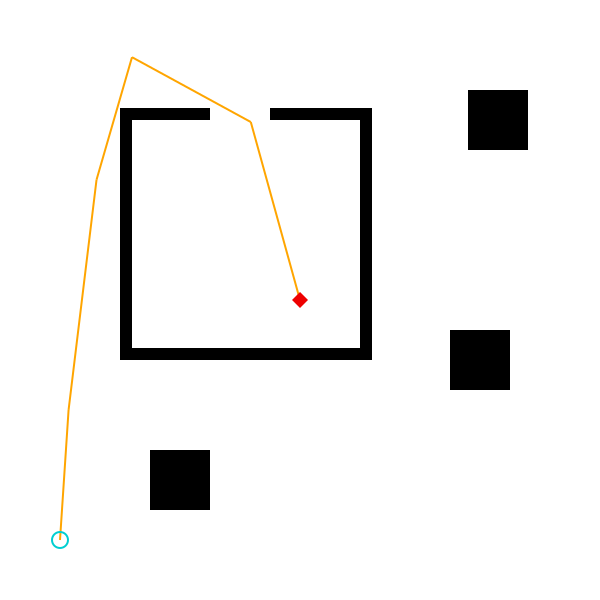

In [17]:
visualize() do
    draw_trace(Dict(:start => start,
                    :dest => dest,
                    :scene => scene,
                    :path => example_path.points);
               should_draw_measurements=false)
end

We also need a model for how the agent moves along its path.
We will assume that the agent moves along its path a constant speed. The file
loaded above also defines a method `walk_path(path, speed, dt, num_ticks)` 
that computes the locations of the agent at a set of timepoints 
(a vector of `Point`s sampled at time intervals of `dt` starting at time `0.`),
given the path and the speed of the agent:

In [18]:
speed = 1.
dt = 0.1
num_ticks = 10;
example_locations = walk_path(example_path, speed, dt, num_ticks)
println(example_locations)

Point[Point(0.1, 0.1), Point(0.1065799096841861, 0.19978328912472249), Point(0.11315981936837219, 0.29956657824944494), Point(0.12426899298433902, 0.39892591369258895), Point(0.13632121136024217, 0.49819697711098665), Point(0.1483734297361453, 0.5974680405293843), Point(0.16042564811204849, 0.696739103947782), Point(0.18765789506337655, 0.7929126054299245), Point(0.2154632687721767, 0.8889691574860646), Point(0.2934615459623094, 0.8645519611788788)]


Now, we are prepated to write our generative model for the motion of the agent.

In [19]:
@gen function agent_model(
        scene::Scene, dt::Float64, num_ticks::Int, 
        planner_params::PlannerParams)

    # sample the start point of the agent from the prior
    start_x ~ uniform(0, 1)
    start_y ~ uniform(0, 1)
    start = Point(start_x, start_y)

    # sample the destination point of the agent from the prior
    dest_x ~ uniform(0, 1)
    dest_y ~ uniform(0, 1)
    dest = Point(dest_x, dest_y)

    # plan a path that avoids obstacles in the scene
    maybe_path = plan_path(start, dest, scene, planner_params)
    planning_failed = maybe_path === nothing
    
    # sample the speed from the prior
    speed ~ uniform(0.3, 1)

    if planning_failed   
        # path planning failed; assume agent stays at start location indefinitely
        locations = fill(start, num_ticks)
    else   
        # path planning succeeded; move along the path at constant speed
        locations = walk_path(maybe_path, speed, dt, num_ticks)
    end

    # generate noisy measurements of the agent's location at each time point
    noise = 0.01
    for (i, point) in enumerate(locations)
        x = {:meas => (i, :x)} ~ normal(point.x, noise)
        y = {:meas => (i, :y)} ~ normal(point.y, noise)
    end

    return (planning_failed, maybe_path)
end;

We can now perform a traced execution of `agent_model` and examine the
random choices it made:

### Exercise

Using `simulate` (or `generate`, without any constraints) to sample a trace,
get the random choices made by this model. Parameterize the planner using
`PlannerParams` with the same parameters as above.

In [26]:
trace = Gen.simulate(agent_model, (scene, dt, num_ticks, planner_params));

In [27]:
Gen.get_choices(trace)

│
├── :start_x : 0.31581391364685096
│
├── :dest_y : 0.03204875921319694
│
├── :start_y : 0.4243988730539322
│
├── :dest_x : 0.6453368246348914
│
├── :speed : 0.3325255769177788
│
└── :meas
    │
    ├── (3, :x) : 0.3415081524365207
    │
    ├── (4, :y) : 0.504392610405306
    │
    ├── (7, :x) : 0.3789934311586476
    │
    ├── (2, :y) : 0.44935618435793806
    │
    ├── (10, :y) : 0.7069171884312242
    │
    ├── (5, :y) : 0.5333766946743295
    │
    ├── (4, :x) : 0.36258921056945437
    │
    ├── (2, :x) : 0.34409390302676124
    │
    ├── (10, :x) : 0.42156901476768155
    │
    ├── (8, :y) : 0.6357898234536529
    │
    ├── (1, :y) : 0.4257862039163285
    │
    ├── (5, :x) : 0.3610943264771838
    │
    ├── (6, :y) : 0.5593089532320016
    │
    ├── (9, :y) : 0.6635089738491935
    │
    ├── (8, :x) : 0.37563885555515997
    │
    ├── (3, :y) : 0.4723248418033776
    │
    ├── (1, :x) : 0.3253500148598211
    │
    ├── (6, :x) : 0.3649039191427499
    │
    ├── (7, :y) : 0.6076

<!-- # BEGIN ANSWER KEY 2A.1

planner_params = PlannerParams(rrt_iters=600, rrt_dt=3.0,
                               refine_iters=3500, refine_std=1.)
trace = Gen.simulate(agent_model, (scene, dt, num_ticks, planner_params));
choices = Gen.get_choices(trace)
display(choices)

# END ANSWER KEY -->
<hr>

Next we explore the assumptions of the model by sampling many traces from the
generative function and visualizing them. We have created a visualization
specialized for this generative function in the file we included above.
It also defined a `visualize_grid` method to plot traces in a grid.

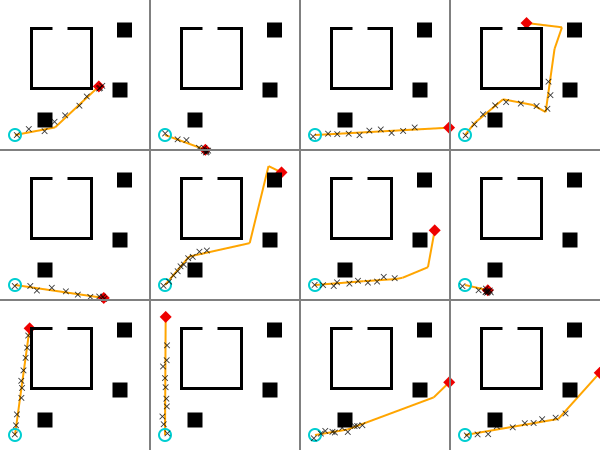

In [28]:
# Let's visualize several traces of the function, with the start location fixed to
# a point in the lower-left corner:
constraints = Gen.choicemap()
constraints[:start_x] = 0.1
constraints[:start_y] = 0.1

traces = [Gen.generate(
    agent_model, (scene, dt, num_ticks, planner_params), constraints
    )[1] for i in 1:12];
visualize_grid(traces, 4, 600; separators="gray") do trace, frame
    draw_trace(trace, frame; draw_measurements=true, markersize=6)
end

In this visualization, the measured coordinates at each
time point are represented by black $\times$ marks. The path, if path planning was
succesful, is shown as an orange line from the start point to the destination
point. Notice that the speed of the agent is different in each case. Also note that
the we observe the agent for a fixed amount of time, in which they may or may not
finish walking their planned path.

<hr>

### Exercise

Edit the constraints passed to the inference algorithm:

1. Constrain the start of the agent to be at $x = 0.9$, $y = 0.1$.
2. Constrain the destination of the agent to be at $x = 0.9$, $y = 0.8$.


Visualize the resulting prior. We have provided some starter code.

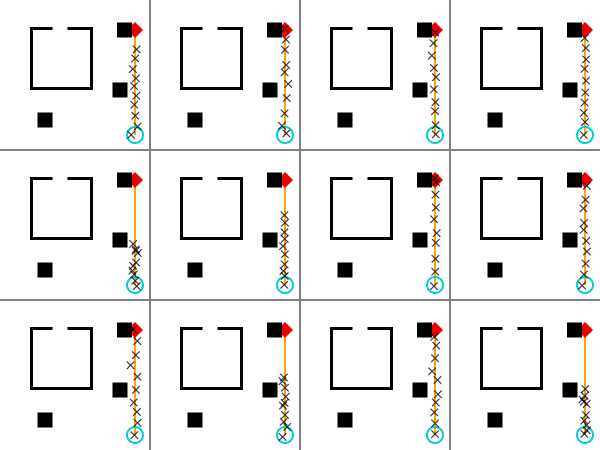

In [29]:
constraints = Gen.choicemap()
constraints[:start_x] = 0.9
constraints[:start_y] = 0.1
constraints[:dest_x] = 0.9
constraints[:dest_y] = 0.8

traces_constrained = []
for i in 1:12
    # Modify the following line:
    (trace_constrained, _) = Gen.generate(agent_model, (scene, dt, num_ticks, planner_params), constraints)
    push!(traces_constrained, trace_constrained)
end

# Visualize:
visualize_grid(traces_constrained, 4, 600; separators="gray") do trace, frame
    draw_trace(trace, frame; draw_measurements=true)
end

<!-- # BEGIN ANSWER KEY 2A.2

constraints = Gen.choicemap()
constraints[:start_x] = 0.9
constraints[:start_y] = 0.1

constraints[:dest_x] = 0.9
constraints[:dest_y] = 0.8

traces_constrained = []
for i in 1:12
    # Modify the following line:
    (trace_constrained, _) = Gen.generate(agent_model, (scene, dt, num_ticks, planner_params), constraints)
    push!(traces_constrained, trace_constrained)
end

# Visualize:
visualize_grid(traces_constrained, 4, 600; separators="gray") do trace, frame
    draw_trace(trace, frame; draw_measurements=true)
end

# END ANSWER KEY -->
<hr>

### Exercise
The `rrt_iters` field of `PlannerParams` is the number of iterations of the RRT
algorithm to use. The `refine_iters` field of `PlannerParams` is the number of
iterations of path refinement. These parameters affect the distribution on
paths of the agent. Visualize traces of the `agent_model` with a couple of
different settings of these two parameters to the path planning algorithm for
fixed starting point and destination point. Try setting them to smaller
values. Discuss.

We have provided starter code.

In [30]:
constraints = Gen.choicemap()
constraints[:start_x] = 0.1
constraints[:start_y] = 0.1;

Modify the `PlannerParams` in the cell below.

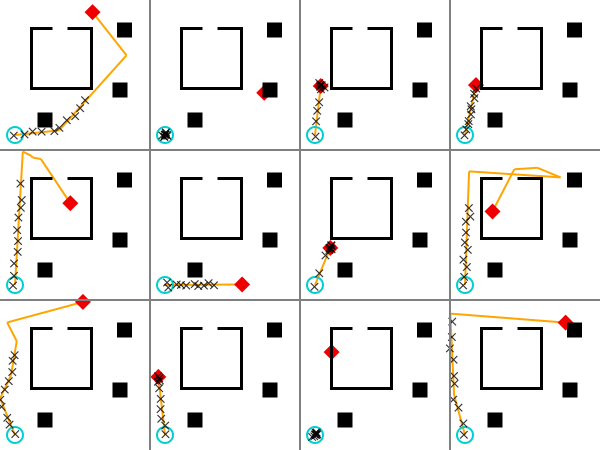

In [48]:
planner_params = PlannerParams(
    rrt_iters=300, rrt_dt=3.0, refine_iters=10, refine_std=1.) # < change this line>

traces = [Gen.generate(agent_model, (scene, dt, num_ticks, planner_params), constraints)[1] for i in 1:12];
visualize_grid(traces, 4, 600; separators="gray") do trace, frame 
    draw_trace(trace, frame; draw_measurements=true)
end

For smaller number of iterations of the RRT algorithm, we are unable to find any path from the start to the destination, while smaller number of refinement steps finds the same number of paths but does not optimize the paths well, taking instead just any path from the start to the destination. This aligns perfectly with intuition: the number of steps of the RTT algorithm determines how many possible endpoints we can find, while the number of refinement steps determines how much we optimize the path once we've found it.

<hr>

For the next few sections of the notebook, let's reset any variables that may have changed during your exploration with the model.

In [49]:
start = Point(0.1, 0.1)
dt = 0.1
num_ticks = 10
planner_params = PlannerParams(rrt_iters=600, rrt_dt=3.0,
                               refine_iters=3500, refine_std=1.);

We will infer the destination of the agent for the given sequence of observed locations:

In [50]:
measurements = [
    Point(0.0980245, 0.104775),
    Point(0.113734, 0.150773),
    Point(0.100412, 0.195499),
    Point(0.114794, 0.237386),
    Point(0.0957668, 0.277711),
    Point(0.140181, 0.31304),
    Point(0.124384, 0.356242),
    Point(0.122272, 0.414463),
    Point(0.124597, 0.462056),
    Point(0.126227, 0.498338)];

<hr>

### Exercise

Run inference using Gen's built-in importance resampling implementation. Use
50 importance samples (`amt_computation`). 

To see how to use the built-in importance resampling function, run
```?Gen.importance_resampling``` or check out the
[documentation](https://www.gen.dev/dev/ref/importance/#Gen.importance_resampling).

We have provided some starter code.

In [51]:
?Gen.importance_resampling

```
(trace, lml_est) = importance_resampling(model::GenerativeFunction,
    model_args::Tuple, observations::ChoiceMap, num_samples::Int,
    verbose=false)

(traces, lml_est) = importance_resampling(model::GenerativeFunction,
    model_args::Tuple, observations::ChoiceMap,
    proposal::GenerativeFunction, proposal_args::Tuple,
    num_samples::Int, verbose=false)
```

Run sampling importance resampling, returning a single trace.

Unlike `importance_sampling`, the memory used constant in the number of samples.

Setting `verbose=true` prints a progress message every sample.


In [68]:
function do_inference(
        scene::Scene, dt::Float64, num_ticks::Int, 
        planner_params::PlannerParams, 
        start::Point, measurements::Vector{Point}, amount_of_computation::Int)
    
    # Constrain the observed measurements.
    observations = Gen.choicemap()
    observations[:start_x] = start.x
    observations[:start_y] = start.y
    for (i, m) in enumerate(measurements)
        observations[:meas => (i, :x)] = m.x
        observations[:meas => (i, :y)] = m.y
    end
    
    trace, _ = Gen.importance_resampling(agent_model, (scene, dt, num_ticks, planner_params), observations, amount_of_computation)
    return trace
end;

<!-- # BEGIN ANSWER KEY 2A.3

function do_inference(
        scene::Scene, dt::Float64, num_ticks::Int, 
        planner_params::PlannerParams, 
        start::Point, measurements::Vector{Point}, amount_of_computation::Int)
    
    # Constrain the observed measurements.
    observations = Gen.choicemap()
    observations[:start_x] = start.x
    observations[:start_y] = start.y
    for (i, m) in enumerate(measurements)
        observations[:meas => (i, :x)] = m.x
        observations[:meas => (i, :y)] = m.y
    end
    
    # Call importance_resampling to obtain a likely trace consistent
    # with our observations.
    (trace, _) = Gen.importance_resampling(
        agent_model, (scene, dt, num_ticks, planner_params),
        observations, amount_of_computation)
    
    return trace
end;

# END ANSWER KEY -->
#### Visualize your answer
Below, we run this algorithm 500 times, to generate 500 approximate samples
from the posterior distribution on the destination. The inferred destinations
should appear as red rhombuses on the map. The following function
visualizes the paths overlaid on the scene.

In [69]:
function visualize_inference(measurements, scene, start; computation_amt=50, samples=1000)
    visualize() do
        for i in 1:samples
            trace = do_inference(scene, dt, num_ticks, planner_params, start, measurements, computation_amt)
            draw_trace(trace; draw_measurements=true, draw_path=false)
        end
    end
end;


And now we run it! Note that this might take a while.

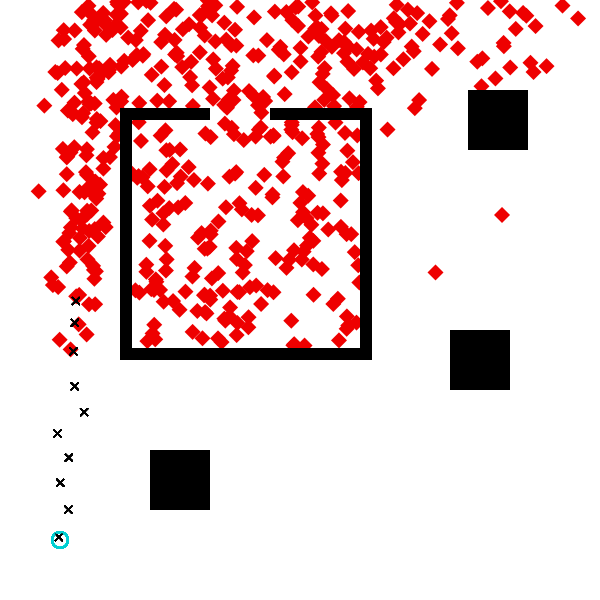

In [70]:
visualize_inference(
    measurements, scene, start, computation_amt=100, samples=500)

The algorithm has made reasonable inferences about where the agent was likely
trying to go.

Note that the above illustration takes a while to produce. This is
because computing each endpoint requires sampling 100 times from the default proposal (which
runs the RRT planner). When our models contain more expensive components, like
the path-planner, the computational demands of inference increase accordingly.
This motivates us to find more efficient inference algorithms, that will
require fewer model evaluations to produce good results.

<hr>

### Exercise

In this problem, you'll explore the effect of changing the _scene_ on the
inferences we make about the agent. Below, we've reproduced the code for
constructing the scene in which we performed inference above. Modify the scene
so that there is an opening into the "room" along the _bottom_ wall, in
addition to the already-existing door along top wall. Otherwise, the scene
should be identical to the one above.

Rerun inference. The results should be qualitatively different from the
results generated above, even though the observed movements of the agent are
identical. **Write a one- or two-sentence description of how the results are
different, and why.** Please address:

1. Why would a _human_ make different inferences about the agent's likely
   destination in the two different scenes?
2. To what extent does the _model_ succeed in producing qualitiatively
   different results in the two scenes? Why? (Concretely, why are certain
   proposals more often rejected by importance sampling in the two-door scene
   than in the one-door scene?)

In [78]:
scene_2doors = Scene(xmin=0, xmax=1, ymin=0, ymax=1)

# Add the three blocks.
add_obstacle!(scene_2doors, make_square(Point(0.30, 0.20), 0.1))
add_obstacle!(scene_2doors, make_square(Point(0.83, 0.80), 0.1))
add_obstacle!(scene_2doors, make_square(Point(0.80, 0.40), 0.1))

# Add the walls. You will need to change this code. In particular, you will need to edit 
# one of these lines (the one that constructs the bottom wall of the room) and add one new line
# (because in order to create the "door", you will actually need to represent the bottom wall
# as two separate rectangular obstacles -- as the sample code already does for the top wall).
horizontal = false
vertical = true
wall_thickness = 0.02
add_obstacle!(scene_2doors, make_line(horizontal, Point(0.60 - 0.15, 0.40), 0.15 + wall_thickness, wall_thickness))
add_obstacle!(scene_2doors, make_line(horizontal, Point(0.20, 0.40), 0.15, wall_thickness))
add_obstacle!(scene_2doors, make_line(vertical, Point(0.60, 0.40), 0.40, wall_thickness))
add_obstacle!(scene_2doors, make_line(horizontal, Point(0.60 - 0.15, 0.80), 0.15 + wall_thickness, wall_thickness))
add_obstacle!(scene_2doors, make_line(horizontal, Point(0.20, 0.80), 0.15, wall_thickness))
add_obstacle!(scene_2doors, make_line(vertical, Point(0.20, 0.40), 0.40, wall_thickness));

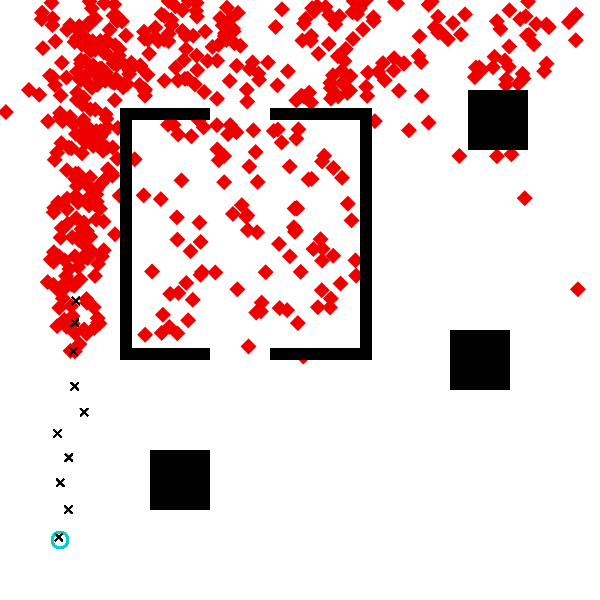

In [79]:
# Perform and visualize inference:
visualize_inference(measurements, scene_2doors, start, computation_amt=100, samples=500)

**Free response:** What changed about the inferences when you changed the scene,
and why? You might address:

1. Why would a _human_ make different inferences about the agent's likely
   destination in the two different scenes?
2. To what extent does the _model_ succeed in producing qualitiatively
   different results in the two scenes? (Concretely, why are certain proposals
   more often rejected by importance sampling in the two-door scene than in
   the one-door scene?)

When we added the bottom door, we removed a lot of the possible locations inside the room that the agent might travel to. This indicates that there is a lot more density of end destinations outside the room, with much fewer inside the room. A human would make a similar inference, because if the goal was inside the room, the paths through the bottom door might be shorter than the paths around the back. The initial scene shows a more or less uniform probability distribution across the relevant outside destinations, which is very different from the second; thus, I think the model does a pretty good job of matching this behavior qualitatively. It rejects the paths in the room more, since those are less likely to match the observations given the second door.

However, the model still predicts a decently high likelyhood of the end goal being in the room, which I would disagree with. This might indicate that the model does not do a good job of determining the exact most-efficient paths, as it believes that some paths that agree with the observations still go to the room.

<hr>
<!-- # BEGIN ANSWER KEY 2.4

scene_2doors = Scene(xmin=0, xmax=1, ymin=0, ymax=1)

# Add the three blocks.
add_obstacle!(scene_2doors, make_square(Point(0.30, 0.20), 0.1))
add_obstacle!(scene_2doors, make_square(Point(0.83, 0.80), 0.1))
add_obstacle!(scene_2doors, make_square(Point(0.80, 0.40), 0.1))

horizontal = false
vertical = true
wall_thickness = 0.02
add_obstacle!(scene_2doors, make_line(horizontal, Point(0.60 - 0.15, 0.40), 0.15 + wall_thickness, wall_thickness))
add_obstacle!(scene_2doors, make_line(horizontal, Point(0.20, 0.40), 0.15, wall_thickness))
add_obstacle!(scene_2doors, make_line(vertical, Point(0.60, 0.40), 0.40, wall_thickness))
add_obstacle!(scene_2doors, make_line(horizontal, Point(0.60 - 0.15, 0.80), 0.15 + wall_thickness, wall_thickness))
add_obstacle!(scene_2doors, make_line(horizontal, Point(0.20, 0.80), 0.15, wall_thickness))
add_obstacle!(scene_2doors, make_line(vertical, Point(0.20, 0.40), 0.40, wall_thickness))

# Perform and visualize inference:
visualize_inference(measurements, scene_2doors, start, computation_amt=50, samples=100)

# END ANSWER KEY -->

## 2. Writing a data-driven proposal as a generative function <a name="custom-proposal"></a>

The inference algorithm above used a variant of
[`Gen.importance_resampling`](https://probcomp.github.io/Gen/dev/ref/importance/#Gen.importance_resampling)
that does not take a custom proposal distribution. It uses the default
proposal distribution associated with the generative model. For generative
functions defined using the built-in modeling DSL, the default proposal
distribution is based on *ancestral sampling*, which involves sampling
unconstrained random choices from the distributions specified in the
generative model. Put more simply, each "guess" the inference algorithm
makes about the possible destination of the agent is totally uninformed
by the observed measurements; it is sampled using the prior generative
model's `dest_x` and `dest_y` sampling statements.

We can visualize this default proposal distribution by sampling from it, 
using `Gen.generate` (note, we also could use `Gen.simulate` for the same purpose, since we are not passing any constraints). The cell below shows samples of the agent's destination 
drawn from this distribution.

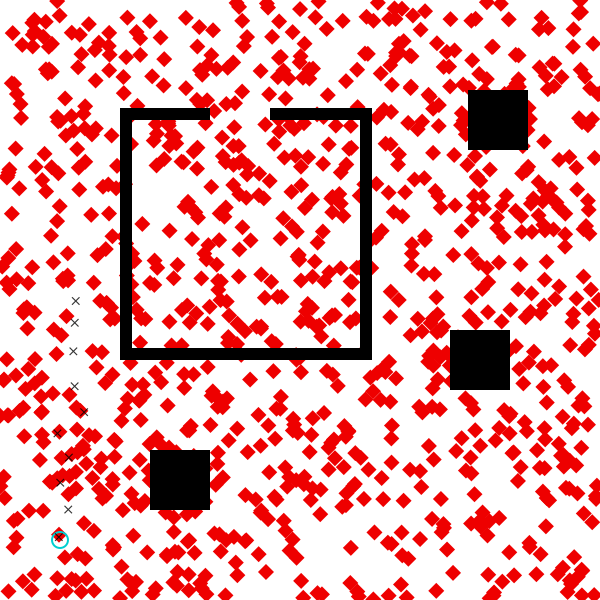

In [80]:
include("../inverse-planning/viz.jl");

traces = [Gen.generate(agent_model, (scene, dt, num_ticks, planner_params))[1] for i in 1:1000]
visualize() do

    for i in 1:1000
        trace, = Gen.generate(agent_model, (scene, dt, num_ticks, planner_params))
        draw_dest(scene, Point(trace[:dest_x], trace[:dest_y]))
    end

    draw_scene(scene)
    draw_start(scene, start)
    draw_measurements(scene, measurements)
end

Intuitively, if we see the data set above (where blue is the starting
location, and the measurements are in black), we might guess that the 
agent is more likely to be heading into the upper part of the scene. This 
is because we don't expect the agent to unecessarily backtrack on its route
to its destnation. A simple heuristic for biasing the proposal distribution 
of the destination using just the first measurement and the last measurement might be:

- If the x-coordinate of the last measurement is greater than the
  x-coordinate of the first measurement, we think the agent is probably
  headed generally to the right. Make values `:dest_x` that are greater than
  the x-coordinate of the last measurement more probable.

- If the x-coordinate of the last measurment is less than the x-coordinate of
  the first measurement, we think the agent is probably headed generally to
  the left. Make values  `:dest_x` that are smaller than the x-coordinate of
  the last measurement more probable.

We can apply the same heuristic separately for the y-coordinate.

To implement this idea, we discretize the x-axis and y-axis of the scene into
bins:

In [81]:
num_x_bins = 5
num_y_bins = 5;

We will propose the x-coordinate of the destination from a
[piecewise_uniform](https://www.gen.dev/dev/ref/distributions/#Gen.piecewise_uniform)
distribution, where we set higher probability for certain bins based on the
heuristic described above and use a uniform continuous distribution for the
coordinate within a bin. The `compute_bin_probs` function below computes the
probability for each bin. The bounds of the scene are given by `min` and
`max`. The coordinates of the first and last measured points respectively are
given by `first` and `last`. We compute the probability by assigning a
"score" to each bin based on the heuristic above --- if the bin should
receive lower probability, it gets a score of 1., and if it should receive
higher probability, it gets a bin of `score_high`, where `score_high` is some
value greater than 1.

In [82]:
function compute_bin_prob(first::Float64, last::Float64, bin::Int, last_bin::Int, score_high)
    last >= first && bin >= last_bin && return score_high
    last < first && bin <= last_bin && return score_high
    return 1.
end

function compute_bin_probs(num_bins::Int, min::Float64, max::Float64, first::Float64, last::Float64, score_high)
    bin_len = (max - min) / num_bins
    last_bin = Int(floor(last / bin_len)) + 1
    probs = [compute_bin_prob(first, last, bin, last_bin, score_high) for bin=1:num_bins]
    total = sum(probs)
    return [p / total for p in probs]
end;

We will see how to automatically tune the value of `score_high` shortly. For
now, we will use a value of 5. Below, we see that for the data set of
measurements, shown above the probabilities of higher bins are indeed 5x
larger than those of lower bins, becuase the agent seems to be headed up.

In [83]:
compute_bin_probs(num_y_bins, scene.ymin, scene.ymax, measurements[1].y, measurements[end].y, 5.)

5-element Vector{Float64}:
 0.058823529411764705
 0.058823529411764705
 0.29411764705882354
 0.29411764705882354
 0.29411764705882354

Next, we write a generative function that applies this heuristic for both the
x-coordinate and y-coordinate, and samples the destination coordinates at
addresses `:dest_x` and `:dest_y`.

In [86]:
@gen function custom_dest_proposal(measurements::Vector{Point}, scene::Scene)

    score_high = 5.
    
    x_first = measurements[1].x
    x_last = measurements[end].x
    y_first = measurements[1].y
    y_last = measurements[end].y
    
    # sample dest_x
    x_probs = compute_bin_probs(num_x_bins, scene.xmin, scene.xmax, x_first, x_last, score_high)
    x_bounds = collect(range(scene.xmin, stop=scene.xmax, length=num_x_bins+1))
    dest_x ~ piecewise_uniform(x_bounds, x_probs)
    
    # sample dest_y
    y_probs = compute_bin_probs(num_y_bins, scene.ymin, scene.ymax, y_first, y_last, score_high)
    y_bounds = collect(range(scene.ymin, stop=scene.ymax, length=num_y_bins+1))
    dest_y ~ piecewise_uniform(y_bounds, y_probs)
    
    return nothing
end;

We can propose values of random choices from the proposal function using
[`Gen.propose`](https://probcomp.github.io/Gen/dev/ref/gfi/#Gen.propose).
This method returns the choices, as well as some other information, which we
won't need for our purposes. For now, you can think of `Gen.propose` as
similar to `Gen.generate` except that it does not produce a full execution
trace (only the choices), and it does not accept constraints. We can see the
random choices for one run of the proposal on our data set:

In [52]:
(proposed_choices, _, _) = Gen.propose(custom_dest_proposal, (measurements, scene))
proposed_choices

│
├── :dest_y : 0.09530847419977109
│
└── :dest_x : 0.024819437423426807


The function below runs the proposal 1000 times. For each run, it generates a
trace of the model where the `:dest_x` and `:dest_y` choices are constrained
to the proposed values, and then visualizes the resulting traces. We make the
proposal a parameter of the function because we will be visualizing the
output distribution of various proposals later in the notebook.

In [94]:
function visualize_custom_destination_proposal(measurements, start, dest_proposal; num_samples=100)
    visualize() do 
        for i=1:num_samples
            (proposed_choices, _) = Gen.propose(dest_proposal, (measurements, scene))
            constraints = choicemap(proposed_choices)
            constraints[:start_x] = start.x
            constraints[:start_y] = start.y
            (trace, _) = Gen.generate(agent_model, (scene, dt, num_ticks, planner_params), constraints)
            draw_dest(scene, Point(trace[:dest_x], trace[:dest_y]))
        end
        draw_scene(scene)
        draw_start(scene, start)
        draw_measurements(scene, measurements)
    end
end;

Let's visualize the output distribution of `custom_dest_proposal` for our
data set:

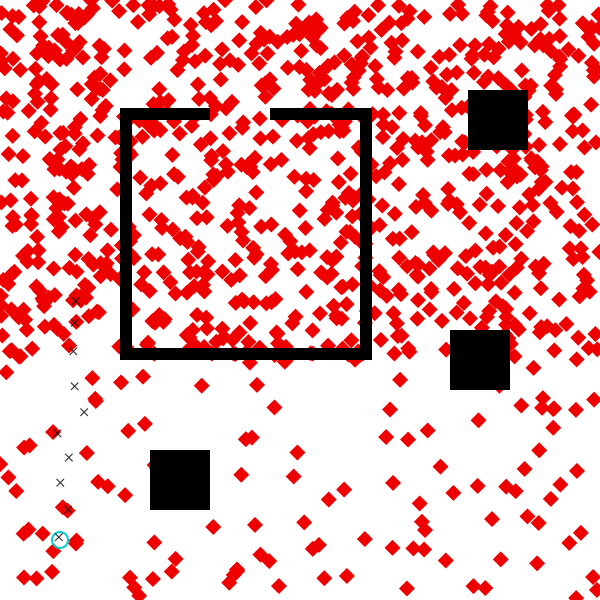

In [95]:
visualize_custom_destination_proposal(measurements, start, custom_dest_proposal, num_samples=1000)

We see that the proposal distribution indeed samples destinations in the top
half of the scene with higher probability than destinations in the bottom
half.

Alone, this is just a heuristic. But we can use it as a proposal for importance sampling, turning it into an asymptotically valid Bayesian inference algorithm. Alternatively, we can view it as a tool for speeding up our naive importance sampler, by focusing computation on regions of the space that are more likely.

## 3. Using a data-driven proposal within importance sampling <a name="using"></a>

We now use our data-driven proposal within an inference algorithm. There is a
second variant of
[`Gen.importance_resampling`](https://probcomp.github.io/Gen/dev/ref/importance/#Gen.importance_resampling)
that accepts a generative function representing a custom proposal. This
proposal generative function makes traced random choices at the addresses of
a subset of the unobserved random choices made by the generative model. In
our case, these addresses are `:dest_x` and `:dest_y`.

<hr>

### Exercise

Implement an inference program that uses this second variant of importance resampling. 


Because we will experiment with different data-driven proposals, we make the
proposal into an agument of our inference program. We assume that the
proposal accepts arguments `(measurements, scene)`.

This time, use only 5 importance samples (`amt_computation`). You can run
`?Gen.importance_resampling` or check out the
[documentation](https://probcomp.github.io/Gen/dev/ref/inference/#Importance-Sampling-1)
to understand how to supply the arguments to invoke this second version of of
importance resampling.

We have provided some starter code.

In [88]:
function do_inference_data_driven(
        dest_proposal::GenerativeFunction,
        scene::Scene, dt::Float64,
        num_ticks::Int, planner_params::PlannerParams,
        start::Point, measurements::Vector{Point}, 
        amount_of_computation::Int)
    
    observations = Gen.choicemap((:start_x, start.x), (:start_y, start.y))
    for (i, m) in enumerate(measurements)
        observations[:meas => (i, :x)] = m.x
        observations[:meas => (i, :y)] = m.y
    end
    
    trace, _ = Gen.importance_resampling(agent_model, (scene, dt, num_ticks, planner_params),
        observations, dest_proposal, (measurements, scene), amount_of_computation)
    
    return trace
end;

function visualize_data_driven_inference(measurements, scene, start, proposal; amt_computation=50, samples=1000)
    visualize() do 
      for i=1:samples
          trace = do_inference_data_driven(proposal, 
              scene, dt, num_ticks, planner_params, start, measurements, amt_computation)
          draw_dest(scene, Point(trace[:dest_x], trace[:dest_y]))
      end
        draw_scene(scene)
        draw_start(scene, start)
        draw_measurements(scene, measurements)
    end
end;

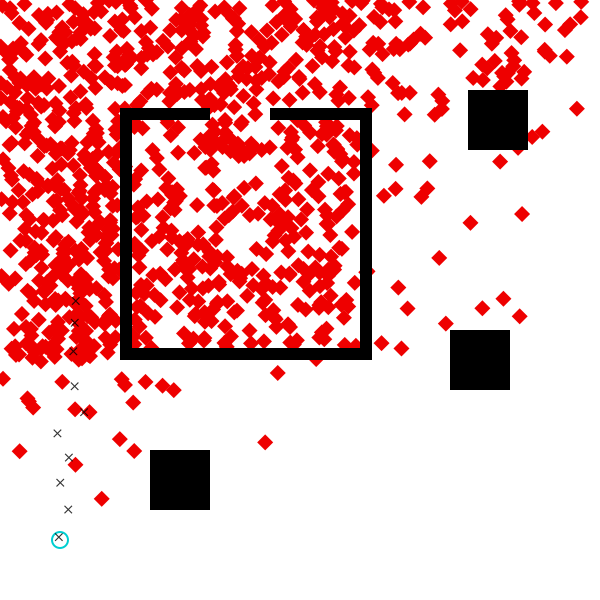

In [89]:
visualize_data_driven_inference(measurements, scene, start, custom_dest_proposal; amt_computation=5, samples=1000)

The code executes much more quickly than before, because we are only taking five proposal samples to generate each.

We compare this to the original algorithm that used the default proposal, for
the same "amount of computation" of 5.

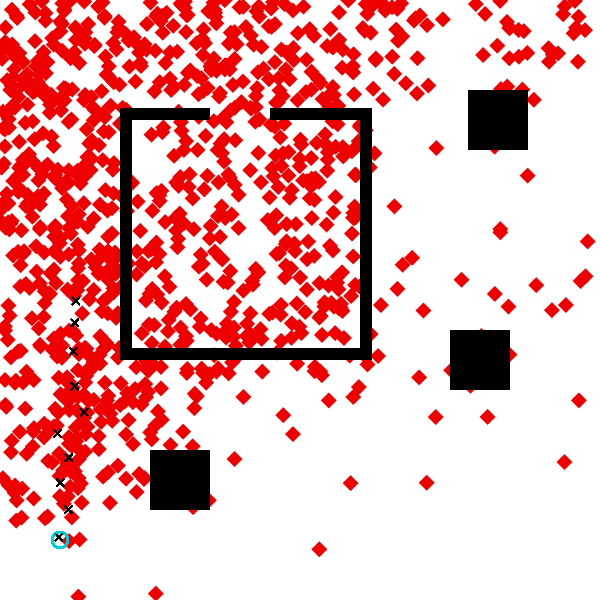

In [57]:
visualize_inference(measurements, scene, start, computation_amt=5, samples=1000)

We should see that the results are somewhat more accurate using the
data-driven proposal.  In particular, there is less probability mass in the
lower left corner when using the data-driven proposal.

<hr>

<!-- # BEGIN ANSWER KEY 2A.5

function do_inference_data_driven(
        dest_proposal::GenerativeFunction,
        scene::Scene, dt::Float64,
        num_ticks::Int, planner_params::PlannerParams,
        start::Point, measurements::Vector{Point}, 
        amount_of_computation::Int)
    
    observations = Gen.choicemap((:start_x, start.x), (:start_y, start.y))
    for (i, m) in enumerate(measurements)
        observations[:meas => (i, :x)] = m.x
        observations[:meas => (i, :y)] = m.y
    end
    
    # invoke the variant of importance_resampling 
    # that accepts a custom proposal (dest_proposal).
    # the arguments to the custom proposal are (measurements, scene)
    (trace, _) = Gen.importance_resampling(agent_model, (scene, dt, num_ticks, planner_params), observations, 
        dest_proposal, (measurements, scene), amount_of_computation)
    
    return trace
end;

function visualize_data_driven_inference(measurements, scene, start, proposal; amt_computation=50, samples=1000)
    visualize() do 
      for i=1:samples
          trace = do_inference_data_driven(proposal, 
              scene, dt, num_ticks, planner_params, start, measurements, amt_computation)
          draw_dest(scene, Point(trace[:dest_x], trace[:dest_y]))
      end
        draw_scene(scene)
        draw_start(scene, start)
        draw_measurements(scene, measurements)
    end
end;

# END ANSWER KEY -->

## 4. Training the parameters of a data-driven proposal <a name="training"></a>

Our choice of the `score_high` value of 5. was somewhat arbitrary. To use
more informed value, we can make `score_high` into a [*trainable
parameter*](https://www.gen.dev/dev/ref/gfi/#Trainable-parameters-1)
of the generative function. Below, we write a new version of the proposal
function that makes `score_high` trainable. However, the optimization
algorithms we will use for training work best with *unconstrained* parameters
(parameters that can take any value on the real line), but `score_high` must
be positive. Therefore, we introduce an unconstrained trainable parameter
mamed `log_score_high`, and use `exp()` to ensure that `score_high` is
positive:

In [90]:
@gen function custom_dest_proposal_trainable(measurements::Vector{Point}, scene::Scene)

    @param log_score_high::Float64
    
    x_first = measurements[1].x
    x_last = measurements[end].x
    y_first = measurements[1].y
    y_last = measurements[end].y
    
    # sample dest_x
    x_probs = compute_bin_probs(num_x_bins, scene.xmin, scene.xmax, x_first, x_last, exp(log_score_high))
    x_bounds = collect(range(scene.xmin, stop=scene.xmax, length=num_x_bins+1))
    dest_x ~ piecewise_uniform(x_bounds, x_probs)
    
    # sample dest_y
    y_probs = compute_bin_probs(num_y_bins, scene.ymin, scene.ymax, y_first, y_last, exp(log_score_high))
    y_bounds = collect(range(scene.ymin, stop=scene.ymax, length=num_y_bins+1))
    dest_y ~ piecewise_uniform(y_bounds, y_probs)
    
    return nothing
end;

We initialize the value of `score_high` to 1. For this value, our custom
proposal gives a uniform distribution, and is the same as the default
proposal.

In [91]:
Gen.init_param!(custom_dest_proposal_trainable, :log_score_high, 0.);

Let's visualize the proposed distribution prior to training to confirm that
it is a uniform distribution.

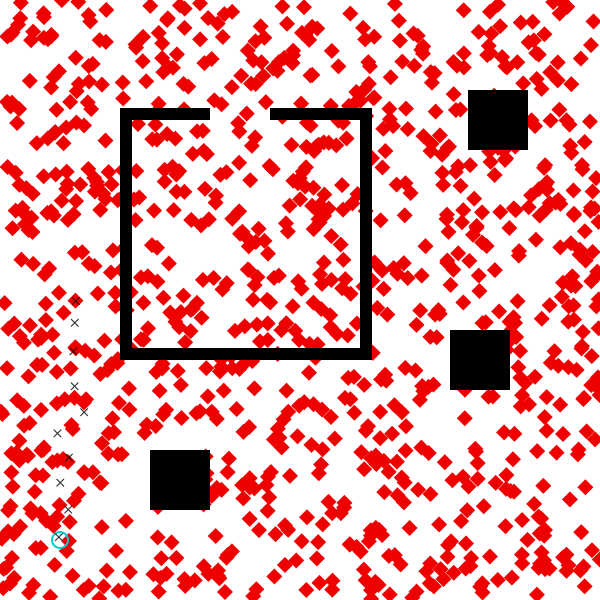

In [97]:
visualize_custom_destination_proposal(measurements, start, custom_dest_proposal_trainable, num_samples=1000)

Now, we train the generative function. First, we will require a
data-generator that generates the training data. The data-generator is a
function of no arguments that returns a tuple of the form `(inputs, constraints)`. 
The `inputs` are the arguments to the generative function
being trained, and the `constraints` contains the desired values of random
choices made by the function for those arguments. For the training
distribution, we will use the distribution induced by the generative model
(`agent_model`), restricted to cases where planning actually succeeded. When
planning failed, the agent just stays at the same location for all time, and
we won't worry about tuning our proposal for that case. The training
procedure will attempt to maximize the expected conditional log probablity
(density) that the proposal function generates the constrained values,
when run on the arguments. 
Note that this is an *average case* objective function --- the resulting proposal 
distribution may perform better on some data sets than others.

In [98]:
function data_generator()
    
    # since these names are used in the global scope, explicitly declare it
    # local to avoid overwriting the global variable
    local measurements
    local choices
    
    # obtain an execution of the model where planning succeeded
    done = false
    while !done
        (choices, _, retval) = Gen.propose(agent_model, (scene, dt, num_ticks, planner_params))
        (planning_failed, maybe_path) = retval       
        done = !planning_failed
    end

    # construct arguments to the proposal function being trained
    measurements = [Point(choices[:meas => (i, :x)], choices[:meas => (i, :y)]) for i=1:num_ticks]
    inputs = (measurements, scene)
    
    # construct constraints for the proposal function being trained
    constraints = Gen.choicemap()
    constraints[:dest_x] = choices[:dest_x]
    constraints[:dest_y] = choices[:dest_y]
    
    return (inputs, constraints)
end;

Next, we choose type of optimization algorithm we will use for training. Gen
supports a set of gradient-based optimization algorithms (see [Optimizing
Trainable
Parameters](https://www.gen.dev/dev/ref/parameter_optimization/#Optimizing-Trainable-Parameters-1)).
Here we will use gradient descent with a fixed step size of 0.001.

In [99]:
update = Gen.ParamUpdate(Gen.FixedStepGradientDescent(0.001), custom_dest_proposal_trainable);

Finally, we use the
[`Gen.train!`](https://probcomp.github.io/Gen/dev/ref/inference/#Gen.train!)
method to actually do the training.

For each epoch, `Gen.train!` makes `epoch_size` calls to the data-generator
to construct a batch of training data for that epoch. Then, it iteratively
selects `num_minibatch` subsets of the epoch training data, each of size
`100`, and applies the update once per minibatch. At the end of the epoch, it
generates another batch of evaluation data (of size `evaluation_size`) which
it uses to estimate the objective function (the expected conditional log
likelihood under the data-generating distribution).

Here, we are running 200 gradient-descent updates, where each update is using
a gradient estimate obtained from 100 training examples. The method prints
the estimate of the objective function after each epoch.

In [100]:
@time scores = Gen.train!(custom_dest_proposal_trainable, data_generator, update,
    num_epoch=200, epoch_size=100, num_minibatch=1, minibatch_size=100, evaluation_size=100, verbose=true);

epoch 1: generating 100 training examples...
epoch 1: training using 1 minibatches of size 100...
epoch 1: evaluating on 100 examples...
epoch 1: est. objective value: 0.055498536476325876
epoch 2: generating 100 training examples...
epoch 2: training using 1 minibatches of size 100...
epoch 2: evaluating on 100 examples...
epoch 2: est. objective value: 0.10838056629455563
epoch 3: generating 100 training examples...
epoch 3: training using 1 minibatches of size 100...
epoch 3: evaluating on 100 examples...
epoch 3: est. objective value: 0.13905894945223102
epoch 4: generating 100 training examples...
epoch 4: training using 1 minibatches of size 100...
epoch 4: evaluating on 100 examples...
epoch 4: est. objective value: 0.1727902934986631
epoch 5: generating 100 training examples...
epoch 5: training using 1 minibatches of size 100...
epoch 5: evaluating on 100 examples...
epoch 5: est. objective value: 0.24149227543565766
epoch 6: generating 100 training examples...
epoch 6: traini

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1664
┌ Warning: backend `GR` is not installed.
└ @ Plots ~/.julia/packages/Plots/M4dfL/src/backends.jl:37
[ Info: GR


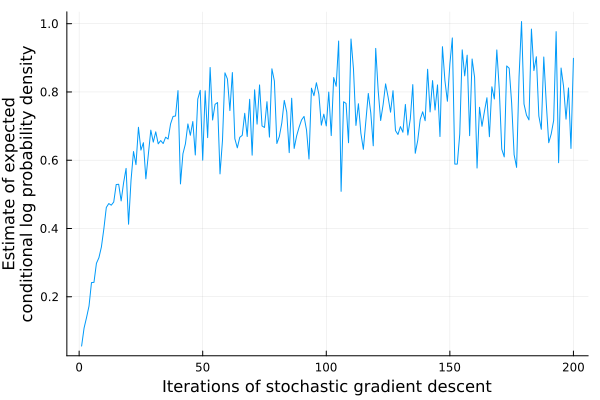

In [101]:
using Plots
plot(scores,
    xlabel="Iterations of stochastic gradient descent",
    ylabel="Estimate of expected\nconditional log probability density", 
    label=nothing)

We can read out the new value for `score_high`:

In [102]:
println(exp(Gen.get_param(custom_dest_proposal_trainable, :log_score_high)))

9.24893861345212


We see that the optimal value of the parameter is indeed larger than our
initial guess. This validates that the heuristic is indeed a useful one. We
visualize the proposal distribution below:

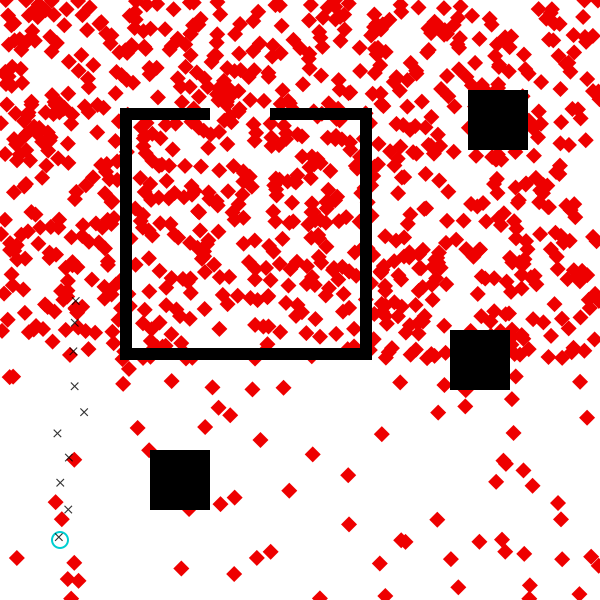

In [103]:
visualize_custom_destination_proposal(
    measurements, start, custom_dest_proposal_trainable, 
    num_samples=1000)

We can visualize the results of inference, using this newly trained proposal:

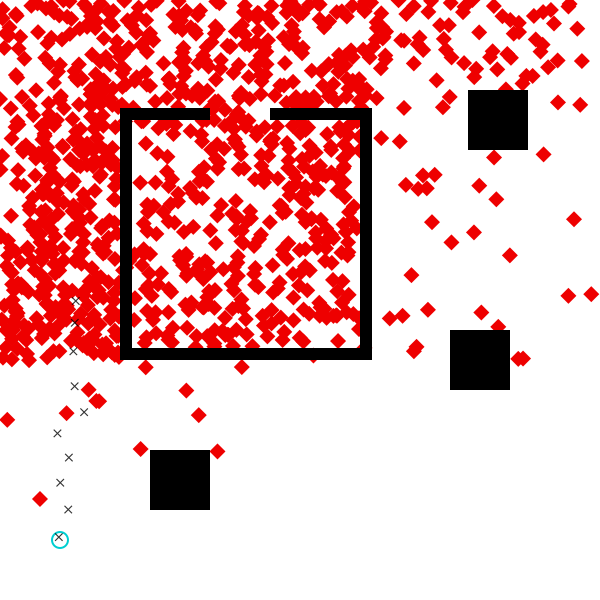

In [104]:
visualize_data_driven_inference(
    measurements, scene, start, custom_dest_proposal_trainable,
    amt_computation=5, samples=1000)

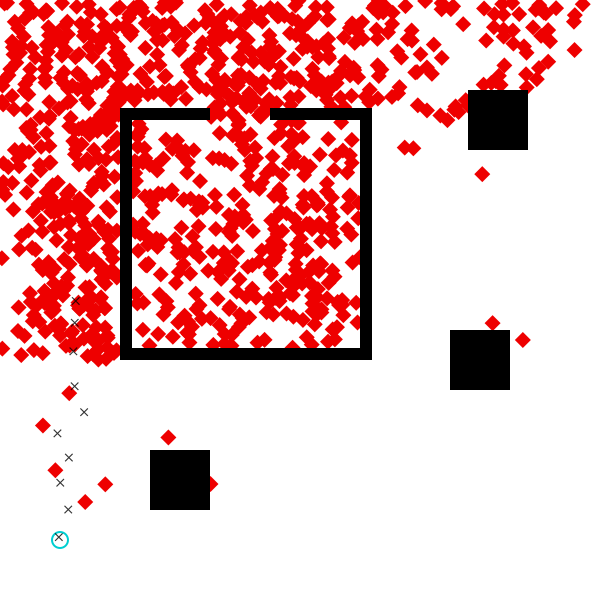

In [105]:
visualize_data_driven_inference(
    measurements, scene, start, custom_dest_proposal_trainable,
    amt_computation=10, samples=1000)

------------

### Exercise

Can you devise a data-driven proposal for the speed of the agent? If so, would you
expect it to work equally well on all data sets?

I think one way of modeling the speed of the agent is to assume that the agent tends to move at a constant speed. Thus, when we observe a new point, we infer that they are more likely to continue moving at that speed, and so we increase our probability of them moving to a circle of radius equal to the size of the previous move.

This will not work well for data sets that are either too noisy or where the agent does not travel at a uniform speed. One way of potentially improving the model is incorporating some probability of speeding up or slowing down, which we could include as a parameter as the variance of the normal centered at the previous move size. This could allow us to update our model appropriately in the cases when the agent moves in a more random fashion, as we would incorporate that additional uncertainty into making sure that we did not overcorrect based on our data.

<hr>

## 5. Writing and training a deep learning based data-driven proposal <a name="deep"></a>

The heuristic data-driven proposal above gave some improvement in efficiency,
but it was very simple. One way of constructing complex data-driven proposals
is to parametrize the proposal with a deep neural network or use another
class of high-capacity machine learning model (e.g. random forest). Here, we
will will write a data-driven proposal for the destination of the agent that
uses deep neural networks. In this section, we do everything manually, without
the aid of neural network libraries. We also provide an [extension to the tutorial](#) that
shows how to use PyTorch to make this process a lot easier.

First, we define a sigmoid function for the nonlinearity in our networks.

In [106]:
nonlinearity(x) = 1.7159 * tanh.(x * 0.66666);

We will use a deep neural network with two hidden layers that takes as input
x- and y- coordinates of the first and last measurement (4 values) and
produces as output a vector of un-normalized probabilities, one for each bin
of the x-dimension. We will later sample `:dest_x` from this distribution.

In [107]:
function dest_x_neural_net(nn_params, x_first::Real, y_first::Real, x_last::Real, y_last::Real)
    (W1, b1, W2, b2, W3, b3) = nn_params
    input_layer = [x_first, y_first, x_last, y_last]
    hidden_layer_1 = nonlinearity(W1 * input_layer .+ b1)
    hidden_layer_2 = nonlinearity(W2 * hidden_layer_1 .+ b2)
    output_layer = exp.(W3 * hidden_layer_2 .+ b3)
    return output_layer
end;

After sampling the value of `:dest_x`, we will use a second deep neural
network with the same structure to sample `:dest_y`.

In [108]:
function dest_y_neural_net(nn_params, x_first::Real, y_first::Real, x_last::Real, y_last::Real)#, dest_x::Real)
    (W1, b1, W2, b2, W3, b3) = nn_params
    input_layer = [x_first, y_first, x_last, y_last]
    hidden_layer_1 = nonlinearity(W1 * input_layer .+ b1)
    hidden_layer_2 = nonlinearity(W2 * hidden_layer_1 .+ b2)
    output_layer = exp.(W3 * hidden_layer_2 .+ b3)
    return output_layer
end;

Now that we have defined our neural networks, we define our new proposal.
This generative function has a number of parameters.

In [109]:
scale_coord(coord, min, max) = (coord / (max - min)) - 0.5

@gen function custom_dest_proposal_neural(measurements::Vector{Point}, scene::Scene)
    @param x_W1::Matrix{Float64}
    @param x_b1::Vector{Float64}
    @param x_W2::Matrix{Float64}
    @param x_b2::Vector{Float64}
    @param x_W3::Matrix{Float64}
    @param x_b3::Vector{Float64}
    
    @param y_W1::Matrix{Float64}
    @param y_b1::Vector{Float64}
    @param y_W2::Matrix{Float64}
    @param y_b2::Vector{Float64}
    @param y_W3::Matrix{Float64}
    @param y_b3::Vector{Float64}
    
    num_x_bins = length(x_b3)
    num_y_bins = length(y_b3)
    
    # scale inputs to be in the range [-0.5, 0.5]
    x_first = scale_coord(measurements[1].x, scene.xmin, scene.xmax)
    x_last = scale_coord(measurements[end].x, scene.xmin, scene.xmax)
    y_first = scale_coord(measurements[1].y, scene.ymin, scene.ymax)
    y_last = scale_coord(measurements[end].y, scene.ymin, scene.ymax)
    
    # sample dest_x
    x_bounds = collect(range(scene.xmin, stop=scene.xmax, length=num_x_bins+1))
    x_probs = dest_x_neural_net((x_W1, x_b1, x_W2, x_b2, x_W3, x_b3), x_first, y_first, x_last, y_last)
    dest_x ~ piecewise_uniform(x_bounds, x_probs / sum(x_probs))
    
    # sample dest_y
    y_bounds = collect(range(scene.xmin, stop=scene.xmax, length=num_y_bins+1))
    y_probs = dest_y_neural_net((y_W1, y_b1, y_W2, y_b2, y_W3, y_b3), x_first, y_first, x_last, y_last)
    dest_y ~ Gen.piecewise_uniform(y_bounds, y_probs / sum(y_probs))
    
    return nothing
end;

We will use 50 hidden units in each of the layers of the two networks:

In [110]:
num_hidden_1 = 50
num_hidden_2 = 50;

Next, we initialize the parameters:

In [111]:
import Random
Random.seed!(3)

init_weight(shape...) = (1. / sqrt(shape[2])) * randn(shape...)

init_x_W1 = init_weight(num_hidden_1, 4)
init_x_W2 = init_weight(num_hidden_2, num_hidden_1)
init_x_W3 = init_weight(num_x_bins, num_hidden_2)

# set parameters for dest_x_neural_net predictor network
init_param!(custom_dest_proposal_neural, :x_W1, init_x_W1)
init_param!(custom_dest_proposal_neural, :x_b1, zeros(num_hidden_1))
init_param!(custom_dest_proposal_neural, :x_W2, init_x_W2)
init_param!(custom_dest_proposal_neural, :x_b2, zeros(num_hidden_2))
init_param!(custom_dest_proposal_neural, :x_W3, init_x_W3)
init_param!(custom_dest_proposal_neural, :x_b3, zeros(num_x_bins))

init_y_W1 = init_weight(num_hidden_1, 4)
init_y_W2 = init_weight(num_hidden_2, num_hidden_1)
init_y_W3 = init_weight(num_x_bins, num_hidden_2)

# set parameters for dest_y_neural_net predictor network
init_param!(custom_dest_proposal_neural, :y_W1, init_y_W1)
init_param!(custom_dest_proposal_neural, :y_b1, zeros(num_hidden_1))
init_param!(custom_dest_proposal_neural, :y_W2, init_y_W2)
init_param!(custom_dest_proposal_neural, :y_b2, zeros(num_hidden_2))
init_param!(custom_dest_proposal_neural, :y_W3, init_y_W3)
init_param!(custom_dest_proposal_neural, :y_b3, zeros(num_y_bins));

Now, we visualize the proposal distribution prior to training:

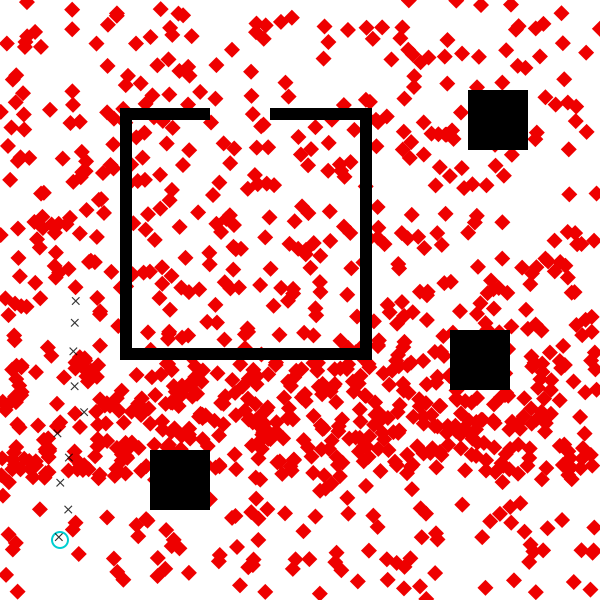

In [112]:
visualize_custom_destination_proposal(measurements, start, custom_dest_proposal_neural, num_samples=1000)

It looks like the initial distribution is roughly uniform, like the default
proposal.

Now we train the network stochastic gradient descent with a fixed step size
of 0.001 that is shared among all of the trainable parameters.

In [113]:
update = Gen.ParamUpdate(Gen.FixedStepGradientDescent(0.001), custom_dest_proposal_neural);

We use 50 epochs of training. In each epoch, we generate 100 training
examples, and we apply 100 gradient updates, where each update is based on
the gradient estimate obtained from a random set of 100 of the trainable
examples. At the end of each epoch, we estimate the objective function value
using 10000 freshly sampled examples. This process takes about 10 minutes to
run on a typical laptop CPU, so we have precomputed the results for you.

```julia
using JLD2
@time scores = Gen.train!(custom_dest_proposal_neural, data_generator, update,
    num_epoch=50, epoch_size=100, num_minibatch=100, minibatch_size=100,
    evaluation_size=1000, verbose=true);
    
let data = Dict()
    for name in [:x_W1, :x_b1, :x_W2, :x_b2, :x_W3, :x_b3, :y_W1, :y_b1, :y_W2, :y_b2, :y_W3, :y_b3]
        data[(:param, name)] = Gen.get_param(custom_dest_proposal_neural, name)
    end
    data[:scores] = scores
    save("params/custom_dest_proposal_neural_trained.jld2", "data", data)
end
```

We load the results here:

In [114]:
using JLD2
scores = let data = JLD2.load("params/custom_dest_proposal_neural_trained.jld2", "data")
    for name in [:x_W1, :x_b1, :x_W2, :x_b2, :x_W3, :x_b3, :y_W1, :y_b1, :y_W2, :y_b2, :y_W3, :y_b3]
        Gen.init_param!(custom_dest_proposal_neural, name, data[(:param, name)])
    end
    data[:scores]
end;

We plot the estimate of the objective function over epochs:

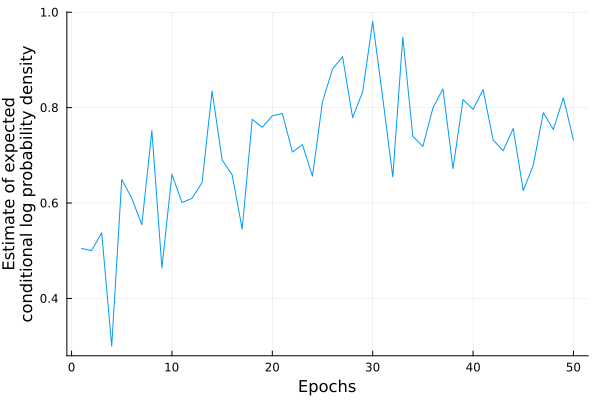

In [115]:
plot(scores,
    xlabel="Epochs", 
    ylabel="Estimate of expected\nconditional log probability density", 
    label=nothing)

Below, we visualize the trained proposal distribution for our data set:

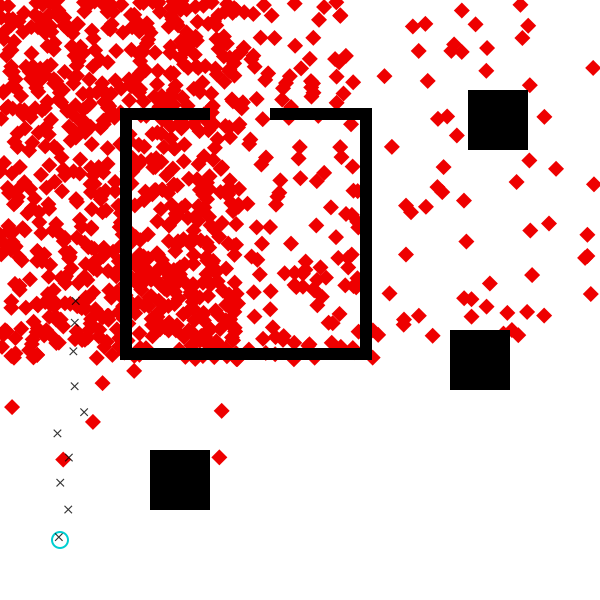

In [116]:
visualize_custom_destination_proposal(measurements, start, custom_dest_proposal_neural, num_samples=1000)

If we run inference with `amt_computation` set to 5, we see that the inferred distribution reflects the bias of the proposal:

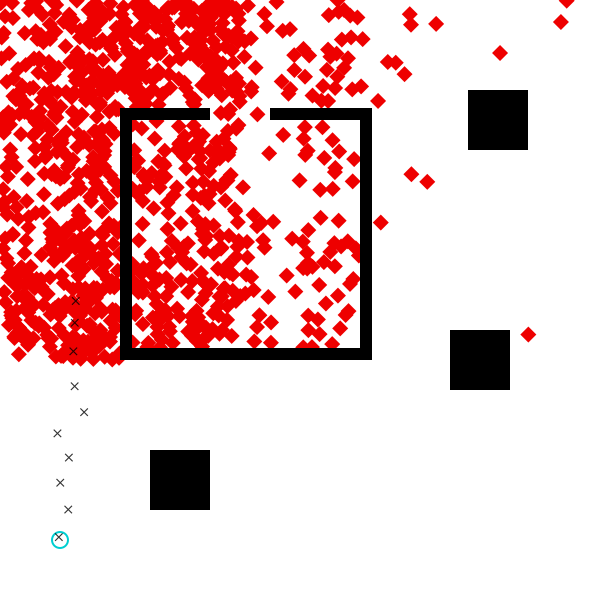

In [117]:
visualize_data_driven_inference(measurements, scene, start, custom_dest_proposal_neural,
    amt_computation=5, samples=1000)

As we increase the amount of computation, the effect of the proposal's bias
is reduced:

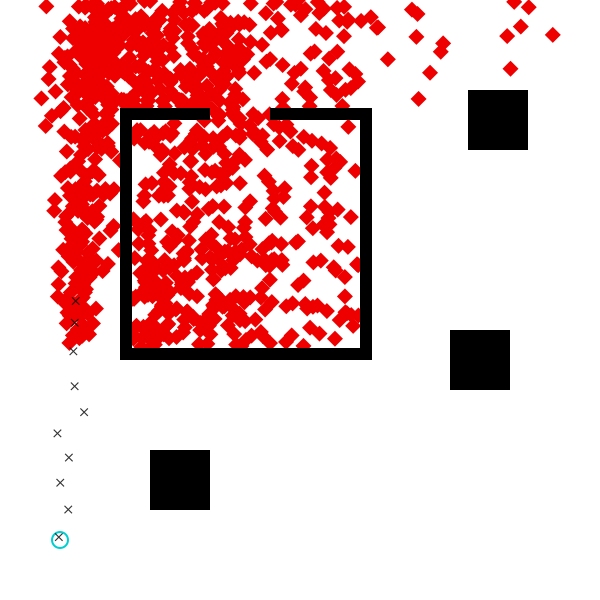

In [ ]:
visualize_data_driven_inference(measurements, scene, start, custom_dest_proposal_neural,
    amt_computation=50, samples=1000)

This bias-correction is more noticeable the more computation we use (though here we only draw 100 approximate posterior samples):

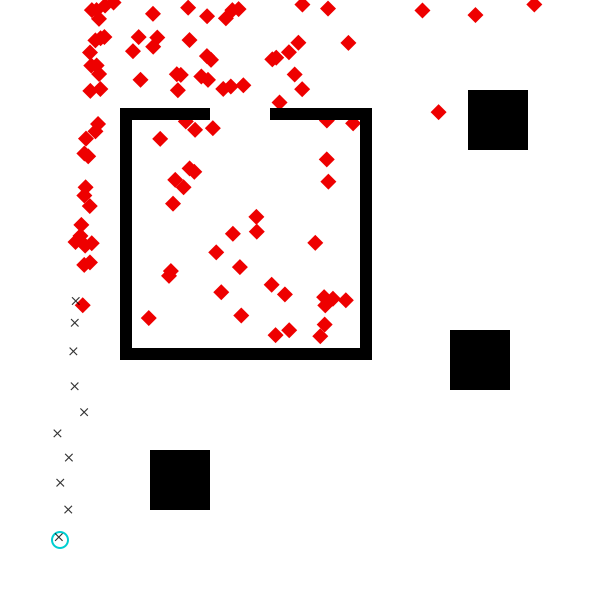

In [91]:
visualize_data_driven_inference(measurements, scene, start, custom_dest_proposal_neural,
    amt_computation=1000, samples=100)

This example highlights an important aspect of importance sampling: it not
only _upweights_ guesses that explain the data well; it also _downweights_ guesses
that are too high-probability under the proposal distribution. That is, if a proposal
is heavily biased toward one region of the state space, all guesses in that region will
be downweighted accordingly. That's why, even though (a) guesses in the left and right halves
of the room are equally likely, and (b) the
proposal stongly prefers the left half of the room, the importance sampling algorithm
samples roughly the same number of points in each half of the room.

In the limit of infinite computation, the distribution induced by importance sampling
converges to the true posterior, independent of the proposal. Indeed, using the
generic proposal with a high amount of computation produces very similar results:

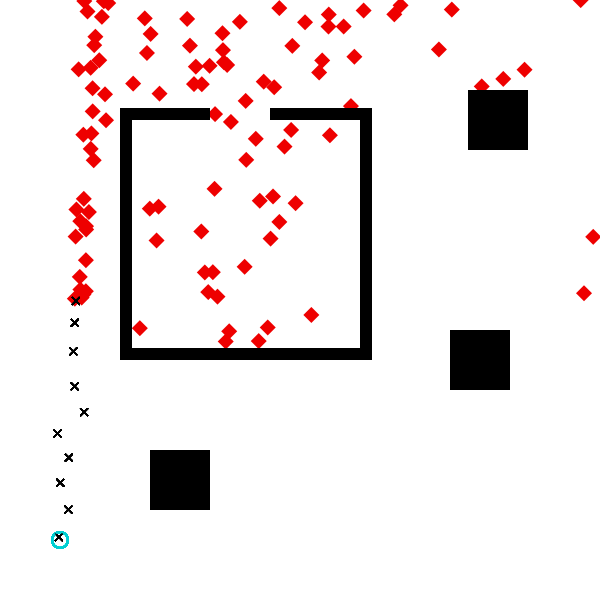

In [93]:
visualize_inference(measurements, scene, start; computation_amt=1000, samples=100)